In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

### Generating dataset

In [97]:
# Set a random seed for reproducibility
np.random.seed(0)

# Constants for the quadratic equation
a,b,c = 1,2,3

# Create a DataFrame with a single feature
n = 100  # number of samples
x = np.linspace(-10, 10, n)  # feature values from -10 to 10
noise = np.random.normal(0, 10, n)  # some random noise
y = a * x**2 + b * x + c + noise  # quadratic equation with noise

data = pd.DataFrame({'X': x, 'y': y})

# round the values to 3 decimal places
data["X"] = data["X"].round(3)
data["y"] = data["y"].round(3)

data.head()

,X,y
0,-10.000,100.641
1,-9.798,83.406
2,-9.596,85.678
3,-9.394,94.867
4,-9.192,87.783


### Visualize the data

In [103]:
df = data.copy()

# Create the figure
fig = go.Figure()

# Add scatter plot trace
fig.add_trace(
    go.Scatter(
        x=df["X"], 
        y=df["y"], 
        mode="markers", 
        marker=dict(opacity=0.7, size=6, color="red",
                    line=dict(color='Black', width=1))
    )
)

# Update layout
fig.update_layout(
    title={
        'text': "Scatter plot of our sample data",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis=dict(
        title="X",
        showline=True,  # Show the X axis line
        tickmode='linear',  # Tick mode to be linear
        # tick0=-10,  # Start tick at 0
        dtick=1,  # Tick at every 1 unit
        linecolor='black',  # X axis line color
    ),
    yaxis=dict(
        title="y",
        showline=True,  # Show the Y axis line
        linecolor='black',  # Y axis line color
    ),
    plot_bgcolor='white',  # Background color
    width=900,
    height=500
)

# Show the figure
fig.show()

### Mean Squared Error

In [104]:
# need to define function to compute mean squared error
def mean_squared_error(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    return np.mean((y-y_hat)**2)

# check if my func is working properly
mean_squared_error([1, 2], [1, 3])

0.5

### Making our first split

In [105]:
# for each feature:
## sort the values of feature
### for every two consecutive rows:
#### take average of feature values and make it split the data into two parts
#### compute the average of both partitions and calculate the MSE
#### if MSE < best MSE, then store this split value

In [106]:
df = data.copy()

# list of all features (only one i.e., 'X' in our case)
features = ["X"]

# iterate over all features
for feature in features:
  # initialize best_params dict
  best_params = {"feature": None, # best feature
                 "split_value": None, # best split value
                 "weighted_mse": np.inf, # weighted mse of two branches
                 "curr_mse": None, # mse at current node
                 "right_yhat": None, # prediction at right branch
                 "left_yhat": None # prediction at left branch
                 }
  # sort the df by current feature
  df = df.sort_values(by=feature)

  # compute the mse at current node
  curr_yhat = np.mean(df['y'].mean())
  curr_mse = mean_squared_error(df['y'], curr_yhat)
  curr_mse = np.round(curr_mse, 3)

  # iterate over all rows of sorted df
  for i in range(1, len(df)):
    # compute average of two consecutive rows
    split_val = (df.iloc[i][feature] + df.iloc[i-1][feature]) / 2
    split_val = np.round(split_val, 3)

    # split the df into two partitions
    left_branch = df[df[feature]<=split_val]
    right_branch = df[df[feature]>split_val]



    # compute the MSE of both partitions:

    left_yhat = np.mean(left_branch["y"]) # prediction will be average of target
    left_yhat = np.round(left_yhat, 3)
    left_mse = mean_squared_error(left_branch["y"], left_yhat) # mse of left
    left_mse = np.round(left_mse, 3)

    right_yhat = np.mean(right_branch["y"]) # prediction will be average of target
    right_yhat = np.round(right_yhat, 3)
    right_mse = mean_squared_error(right_branch["y"], right_yhat) # mse of right
    right_mse = np.round(right_mse, 3)

    # compute weighted MSE
    weighted_mse = ((len(left_branch) * left_mse) + (len(right_branch) * right_mse))/len(df)
    weighted_mse = np.round(weighted_mse, 3)

    # update best_params if weighted_mse is less than previously best_mse
    if weighted_mse <= best_params["weighted_mse"]:
      best_params["weighted_mse"] = weighted_mse
      best_params["split_value"] = split_val
      best_params["feature"] = feature
      best_params["curr_mse"] = curr_mse
      best_params["right_yhat"] = right_yhat
      best_params["left_yhat"] = left_yhat

best_params

{'feature': 'X',
 'split_value': 6.869,
 'weighted_mse': 665.505,
 'curr_mse': 1381.82,
 'right_yhat': 98.929,
 'left_yhat': 25.924}

### Visualize first split

In [107]:
# add vertical line to existing figure
fig.add_vline(x=best_params["split_value"], line_width=3, line_color="black")

# plot right branch split
fig.add_shape(type="line",
x0=best_params["split_value"], y0=best_params["right_yhat"],
x1=10, y1=best_params["right_yhat"],  
line=dict(color="gray", width=3))

# plot left branch split
fig.add_shape(type="line",
x0=-10, y0=best_params["left_yhat"],
x1=best_params["split_value"], y1=best_params["left_yhat"],  
line=dict(color="gray", width=3))

# fig.update_layout(title=
fig.update_layout(
title={
    'text': f"X<={np.round(best_params["split_value"],3)}, MSE={np.round(best_params["curr_mse"],3)}, samples={len(df)}, value={np.round(df["y"].mean(),3)}",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
)

fig.show()

In [108]:
# save the split value at root node
best_split_value_at_root = best_params["split_value"]
best_split_value_at_root

6.869

### Repeat on left partition

In [109]:
# retrieve data at left partition
df = data[data["X"]<=best_split_value_at_root].copy()

features = ["X"]

for feature in features:
    # Reset best params
    best_params = {"feature": None, # best feature
                 "split_value": None, # best split value
                 "weighted_mse": np.inf, # weighted mse of two branches
                 "curr_mse": None, # mse at current node
                 "right_yhat": None, # prediction at right branch
                 "left_yhat": None # prediction at left branch
                 }


    df = df.sort_values(by=feature)

    # compute the mse at current node
    curr_yhat = np.mean(df['y'].mean())
    curr_mse = mean_squared_error(df['y'], curr_yhat)
    curr_mse = np.round(curr_mse, 3)
    for i in range(1, len(df)):
        split_val = (df.iloc[i][feature] + df.iloc[i-1][feature]) / 2
        split_val = np.round(split_val, 3)

        # split the df into two partitions
        left_branch = df[df[feature]<=split_val]
        right_branch = df[df[feature]>split_val]

        # compute the MSE of both patitions

        # predictions of every data point on left side will be equal to average of price
        left_yhat = np.mean(left_branch["y"])
        left_yhat = np.round(left_yhat, 3)
        left_mse = mean_squared_error(left_branch["y"], left_yhat)
        left_mse = np.round(left_mse, 3)

        right_yhat = np.mean(right_branch["y"])
        right_yhat = np.round(right_yhat, 3)
        right_mse = mean_squared_error(right_branch["y"], right_yhat)
        right_mse = np.round(right_mse, 3)

        # weighted MSE
        weighted_mse = ((len(left_branch) * left_mse) + (len(right_branch) * right_mse))/len(df)
        weighted_mse = np.round(weighted_mse, 3)

        if weighted_mse <= best_params["weighted_mse"]:
            best_params["left_yhat"] = left_yhat
            best_params["right_yhat"] = right_yhat
            best_params["weighted_mse"] = weighted_mse
            best_params["split_value"] = split_val
            best_params["feature"] = feature
            best_params["curr_mse"] = curr_mse

best_params

{'feature': 'X',
 'split_value': -6.667,
 'weighted_mse': 348.151,
 'curr_mse': 728.428,
 'right_yhat': 16.101,
 'left_yhat': 64.638}

In [110]:
fig = go.Figure()

fig.add_trace(
go.Scatter(x=df["X"], y=df["y"], mode="markers",marker=dict(opacity=0.7, size=6, color="red",
        line=dict(color='black', width=1)))
)

# old split (right side remains intact)
fig.add_vline(x=best_params["split_value"], line_width=3, line_color="black")



# update left branch splits
# plot right branch split
fig.add_shape(type="line",
x0=best_params["split_value"], y0=best_params["right_yhat"],
x1=best_split_value_at_root, y1=best_params["right_yhat"],  
line=dict(color="gray", width=3))

# plot left branch split
fig.add_shape(type="line",
x0=-10, y0=best_params["left_yhat"],
x1=best_params["split_value"], y1=best_params["left_yhat"],  
line=dict(color="gray", width=3))

# fig.update_layout(title=f"X={np.round(best_params["split_value"],2)}, MSE={np.round(best_params["mse"],2)},samples={len(df)}, value={np.round(df["y"].mean(),2)}")
fig.update_layout(
    title={
        'text': f"Left of root node <br>X<={np.round(best_params["split_value"],2)}, MSE={np.round(best_params["curr_mse"],2)}, samples={len(df)}, value={np.round(df["y"].mean(),2)}",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis=dict(
        title="X",
        showline=True,  
        tickmode='linear',  
        dtick=1,  
        linecolor='black',  
    ),
    yaxis=dict(
        title="y",
        showline=True,  
        linecolor='black',  
    ),
    plot_bgcolor='white',  
    width=700,
    height=500
    )

fig.show()
best_params


{'feature': 'X',
 'split_value': -6.667,
 'weighted_mse': 348.151,
 'curr_mse': 728.428,
 'right_yhat': 16.101,
 'left_yhat': 64.638}

In [111]:
# retrieve data at right partition
df = data[data["X"]>best_split_value_at_root].copy()

features = ["X"]

for feature in features:
    # Reset best params
    best_params = {"feature": None, # best feature
                 "split_value": None, # best split value
                 "weighted_mse": np.inf, # weighted mse of two branches
                 "curr_mse": None, # mse at current node
                 "right_yhat": None, # prediction at right branch
                 "left_yhat": None # prediction at left branch
                 }


    df = df.sort_values(by=feature)

    # compute the mse at current node
    curr_yhat = np.mean(df['y'].mean())
    curr_mse = mean_squared_error(df['y'], curr_yhat)
    curr_mse = np.round(curr_mse, 2)
    for i in range(1, len(df)):
        split_val = (df.iloc[i][feature] + df.iloc[i-1][feature]) / 2
        split_val = np.round(split_val, 3)

        # split the df into two partitions
        left_branch = df[df[feature]<=split_val]
        right_branch = df[df[feature]>split_val]

        # compute the MSE of both patitions

        # predictions of every data point on left side will be equal to average of price
        left_yhat = np.mean(left_branch["y"])
        left_yhat = np.round(left_yhat, 3)
        left_mse = mean_squared_error(left_branch["y"], left_yhat)
        left_mse = np.round(left_mse, 3)

        right_yhat = np.mean(right_branch["y"])
        right_yhat = np.round(right_yhat, 3)
        right_mse = mean_squared_error(right_branch["y"], right_yhat)
        right_mse = np.round(right_mse, 3)

        # weighted MSE
        weighted_mse = ((len(left_branch) * left_mse) + (len(right_branch) * right_mse))/len(df)
        weighted_mse = np.round(weighted_mse, 3)

        if weighted_mse <= best_params["weighted_mse"]:
            best_params["left_yhat"] = left_yhat
            best_params["right_yhat"] = right_yhat
            best_params["weighted_mse"] = weighted_mse
            best_params["split_value"] = split_val
            best_params["feature"] = feature
            best_params["curr_mse"] = curr_mse

best_params

{'feature': 'X',
 'split_value': 8.283,
 'weighted_mse': 95.328,
 'curr_mse': 335.16,
 'right_yhat': 112.587,
 'left_yhat': 81.369}

In [112]:
fig = go.Figure()

fig.add_trace(
go.Scatter(x=df["X"], y=df["y"], mode="markers",marker=dict(opacity=0.7, size=6, color="red",
        line=dict(color='black', width=1)))
)

fig.add_vline(x=best_params["split_value"], line_width=3, line_color="black")


fig.add_shape(type="line",
x0=best_params["split_value"], y0=best_params["right_yhat"],
x1=11, y1=best_params["right_yhat"],  
line=dict(color="gray", width=3))

# plot left branch split
fig.add_shape(type="line",
x0=6.8, y0=best_params["left_yhat"],
x1=best_params["split_value"], y1=best_params["left_yhat"],  
line=dict(color="gray", width=3))

# fig.update_layout(title=f"X={np.round(best_params["split_value"],2)}, MSE={np.round(best_params["mse"],2)},samples={len(df)}, value={np.round(df["y"].mean(),2)}")
fig.update_layout(
    title={
        'text': f"Right of root node <br>X<={np.round(best_params["split_value"],2)}, MSE={np.round(best_params["curr_mse"],2)}, <br>samples={len(df)}, value={np.round(df["y"].mean(),2)}",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis=dict(
        title="X",
        showline=True,  
        tickmode='linear',  
        dtick=1,  
        linecolor='black',  
    ),
    yaxis=dict(
        title="y",
        showline=True,  
        linecolor='black',  
    ),
    plot_bgcolor='white',  
    width=300,
    height=500
    )

fig.show()

**The above gets repeated on further partitions.**

## Generalized code using Recursion:

### Helper functions:
- **mean_squared_error(y_true, y_pred)**: To compute the mean squared error. We have already defined it.
- **get_best_params(df)**: To get the best split (feature, value, current mse, current prediction value) at the given node.

In [49]:

def get_best_params(df):
    for feature in features:
    # initialize best_params dict
        best_params = {"feature": None, # best feature
                 "split_value": None, # best split value
                 "weighted_mse": np.inf, # weighted mse of two branches
                 "curr_mse": None, # mse at current node
                 "right_yhat": None, # prediction at right branch
                 "left_yhat": None # prediction at left branch
                 }
        # sort the df by current feature
        df = df.sort_values(by=feature)

        # iterate over all rows of sorted df
        for i in range(1, len(df)):
            # compute average of two consecutive rows
            split_val = (df.iloc[i][feature] + df.iloc[i-1][feature]) / 2
            split_val = np.round(split_val, 3)

            # split the df into two partitions
            left_branch = df[df[feature]<=split_val]
            right_branch = df[df[feature]>split_val]

            # compute the MSE of both partitions:

            left_yhat = np.mean(left_branch["y"]) # prediction will be average of target
            left_yhat = np.round(left_yhat, 3)
            left_mse = mean_squared_error(left_branch["y"], left_yhat) # mse of left
            left_mse = np.round(left_mse, 3)

            right_yhat = np.mean(right_branch["y"]) # prediction will be average of target
            right_yhat = np.round(right_yhat, 3)
            right_mse = mean_squared_error(right_branch["y"], right_yhat) # mse of right
            right_mse = np.round(right_mse, 3)

            # compute weighted MSE
            weighted_mse = ((len(left_branch) * left_mse) + (len(right_branch) * right_mse))/len(df)
            weighted_mse = np.round(weighted_mse, 3)
            

            # update best_params if weighted_mse is less than previously best_mse
            if weighted_mse <= best_params["weighted_mse"]:
                best_params["left_yhat"] = left_yhat
                best_params["right_yhat"] = right_yhat
                best_params["weighted_mse"] = weighted_mse
                best_params["split_value"] = split_val
                best_params["feature"] = feature
                best_params["curr_mse"] = curr_mse

    return best_params

### Main function

In [113]:
def build_tree(df, max_depth=3, curr_depth=0):
    """Function to build the regression tree recursively"""
    
    if curr_depth>=max_depth:
        prediction = np.round(np.mean(df["y"]), 3)
        print(("--" * curr_depth) + f"Predict: {prediction}")
        return
        
    best_params = get_best_params(df)

    if best_params["feature"] is None or best_params["split_value"] is None:
        prediction = np.round(np.mean(df["y"]), 2)
        print(("--" * curr_depth) + f"Predict: {prediction}")
        return
    
    feature = best_params["feature"]
    split_val = best_params["split_value"]

    # Print the current question (decision rule)
    question = f"{feature} <= {split_val}"
    mse = mean_squared_error(df["y"], df["y"].mean())
    mse = np.round(mse, 3)
    samples = len(df)
    print(("--" * (curr_depth*2)) + ">" + f"{question}, mse: {mse}, samples: {samples}, value: {np.round(df["y"].mean(),3)}")

    left_branch = df[df[feature]<=split_val]
    right_branch = df[df[feature]>split_val]

    # recursive calls for left and right subtrees
    if not left_branch.empty:
        print(("--" * curr_depth) + f"Yes ->")
        build_tree(left_branch, curr_depth=curr_depth+1)

    if not right_branch.empty:
        print(("--" * curr_depth) + f"No ->")
        build_tree(right_branch, curr_depth=curr_depth+1)


In [114]:
build_tree(data)

>X <= 6.869, mse: 1381.82, samples: 100, value: 37.605
Yes ->
---->X <= -6.667, mse: 728.428, samples: 84, value: 25.924
--Yes ->
-------->X <= -9.091, mse: 338.278, samples: 17, value: 64.638
----Yes ->
------Predict: 90.475
----No ->
------Predict: 53.872
--No ->
-------->X <= 3.838, mse: 350.656, samples: 67, value: 16.101
----Yes ->
------Predict: 8.787
----No ->
------Predict: 41.457
No ->
---->X <= 8.283, mse: 335.158, samples: 16, value: 98.929
--Yes ->
-------->X <= 7.879, mse: 59.444, samples: 7, value: 81.369
----Yes ->
------Predict: 78.826
----No ->
------Predict: 87.727
--No ->
-------->X <= 9.495, mse: 123.237, samples: 9, value: 112.587
----Yes ->
------Predict: 105.711
----No ->
------Predict: 126.339


### Draw the decision boundaries and predictions

In [115]:
# sorted split values
splits = [-9.09, -6.67, 3.84, 6.87, 7.88, 8.28, 9.5]  
# corresponding predictions
predictions = [90.48, 53.87, 8.79, 41.46, 78.83, 87.73, 105.71, 126.34]  

# Create a range of x values
x_values = np.linspace(min(splits) - 1, max(splits) + 1, 1000)

# Determine the corresponding y values (predictions) for the x values based on the decision boundaries
y_values = np.piecewise(x_values, [x_values <= splits[0],
                                   (splits[0] < x_values) & (x_values <= splits[1]),
                                   (splits[1] < x_values) & (x_values <= splits[2]),
                                   (splits[2] < x_values) & (x_values <= splits[3]),
                                   (splits[3] < x_values) & (x_values <= splits[4]),
                                   (splits[4] < x_values) & (x_values <= splits[5]),
                                   (splits[5] < x_values) & (x_values <= splits[6]),
                                   x_values > splits[6]], predictions)

# Create a Plotly figure
fig = go.Figure()

fig.add_trace(
        go.Scatter(x=data["X"], y=data["y"], mode="markers", marker=dict(opacity=0.7, size=6, color="red",
                line=dict(color='black', width=1)), name="Actual Values")
    )

# Add a scatter plot for the predictions
fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Predicted Values', line=dict(color="gray")))

# Add vertical lines for each decision boundary
for split in splits:
    fig.add_vline(x=split, line=dict(color="gray", dash="dash"), name=f"Split at {split}")

for split in splits:
    fig.add_vline(x=split, line=dict(color="gray", dash="dash"),
                  annotation_text=f"X={split}", annotation_position="top",
                  annotation=dict(font=dict(size=10, color="gray"), 
                                  showarrow=False, 
                                  xref="x", yref="y", 
                                  textangle=-90))

# Update the figure layout
fig.update_layout(
                  xaxis=dict(title="X",
                             showline=True,
                             linecolor="black",
                             tickmode="linear"),
                  yaxis_title="y",
                  yaxis=dict(title="y",
                             showline=True,
                             linecolor="black"),
                  showlegend=True,
                  plot_bgcolor="white",
                  width=900, height=500)

# Display the figure
fig.show()


### Using Scikit-Learn

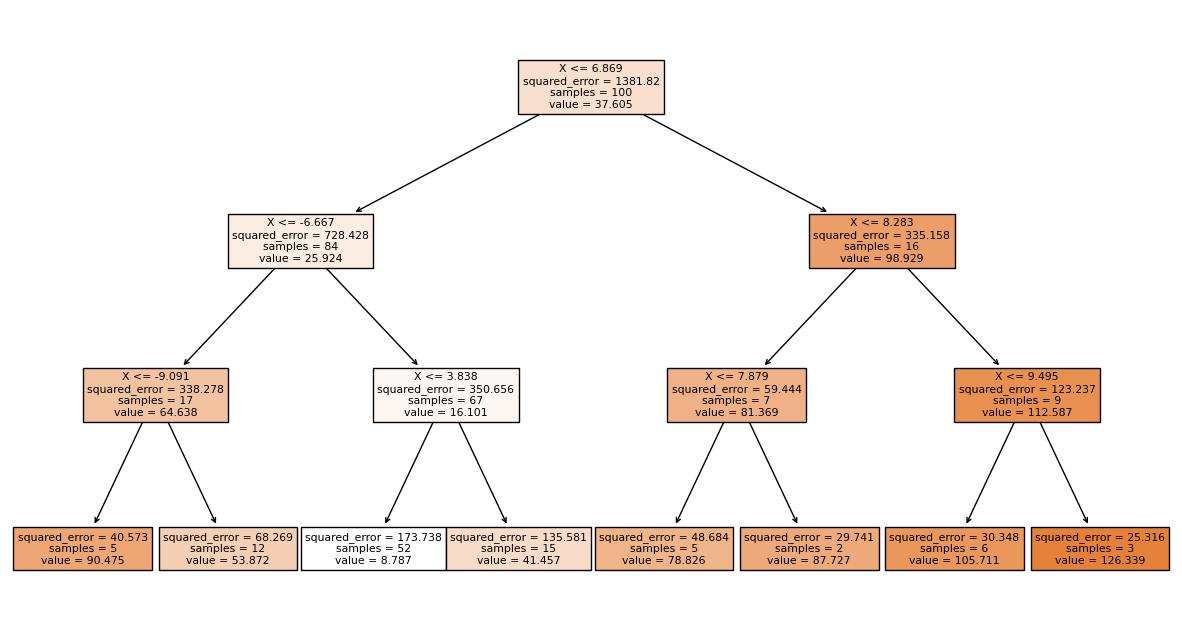

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt


# Fit the regression tree
regressor = DecisionTreeRegressor(max_depth=3)
X = np.array(data["X"]).reshape(100, 1)
y = np.array(data["y"])
regressor.fit(X, y)

# Plot the tree
plt.figure(figsize=(15, 8))
tree.plot_tree(regressor, feature_names=['X'], filled=True)
plt.show()
